## Part 6: Model Comparisons (Test Set)

In this final part of my binary classification comparison series, I'll see how all the different models performed on the as-yet-unseen test set. Everything we've seen so far indicates that the models perform very similarly. Given the nature of the data and the objective of the problem, this isn't all that surprising. We're not likely to see a clear favorite in this comparison, but it's a useful exercise regardless. Specifically, I'll summarize the following:

- First I'll compare precision and recall of all the models. 
- Then I'll examine ROC curves for all models that return probability estimates (all except SVM). 
- Finally, I'll use the ROC analysis to identify which model will provide the best precision given a particular true positive threshold.

First, I'll import everything I need (predictions for all models were previously calculated).

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Import train/val/test
x_train = pickle.load( open( "x_train.pickle", "rb" ) )
x_val = pickle.load( open( "x_val.pickle", "rb" ) )
x_test = pickle.load( open( "x_test.pickle", "rb" ) )
y_train = pickle.load( open( "y_train.pickle", "rb" ) )
y_val = pickle.load( open( "y_val.pickle", "rb" ) )
y_test = pickle.load( open( "y_test.pickle", "rb" ) )
keep_vars10 = pickle.load( open( "keep_vars10.pickle", "rb" ) )

# Import Test Predictions
test_class_pred = pickle.load( open( "test_class_pred.pickle", "rb" ) )
test_prob_pred = pickle.load( open( "test_prob_pred.pickle", "rb" ) )

# As DataFrame
class_pred_df = pd.DataFrame(test_class_pred)

### Precision/Recall by Model

Now I'll plot precision/recall by model, then list these models in order of each measure.

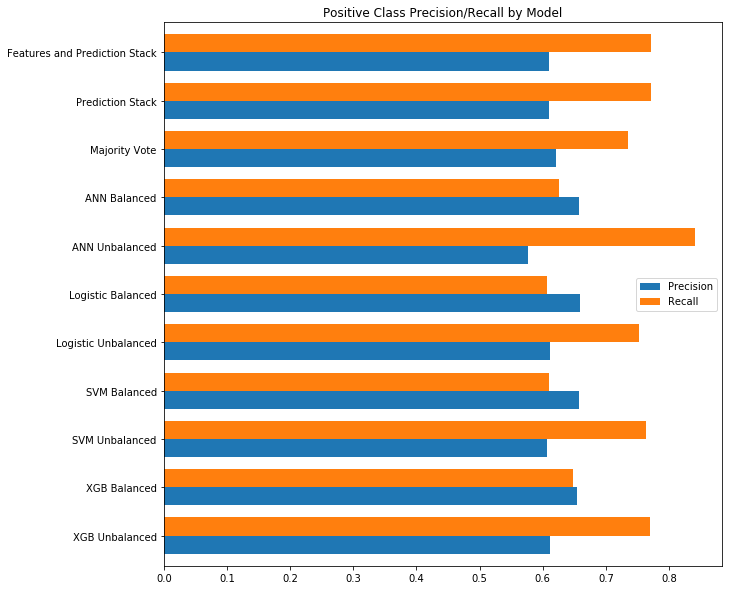

                               Precision    Recall
Logistic Balanced               0.658908  0.606142
SVM Balanced                    0.657960  0.610259
ANN Balanced                    0.657099  0.625126
XGB Balanced                    0.654425  0.648048
Majority Vote                   0.621544  0.735651
Logistic Unbalanced             0.611457  0.752651
XGB Unbalanced                  0.610927  0.769620
Prediction Stack                0.610438  0.771101
Features and Prediction Stack   0.610259  0.770894
SVM Unbalanced                  0.607273  0.763579
ANN Unbalanced                  0.575894  0.841379 


                               Precision    Recall
ANN Unbalanced                  0.575894  0.841379
Prediction Stack                0.610438  0.771101
Features and Prediction Stack   0.610259  0.770894
XGB Unbalanced                  0.610927  0.769620
SVM Unbalanced                  0.607273  0.763579
Logistic Unbalanced             0.611457  0.752651
Majority Vote               

In [3]:
rcParams['figure.figsize'] = [10, 10]

gdf = pd.DataFrame({
    'Precision':[classification_report(y_test,
                                       test_class_pred[model],
                                       output_dict=True)['1.0']['precision'] \
                 for model in test_class_pred],
    'Recall':[classification_report(y_test,
                                    test_class_pred[model],
                                    output_dict=True)['1.0']['recall'] \
              for model in test_class_pred]
}, index = test_class_pred.keys())

gdf.plot.barh(width=.75,
             title='Positive Class Precision/Recall by Model')
plt.show()

# Precision/Recall by Precision
print(gdf.sort_values('Precision',ascending=False),'\n\n')

# Precision/Recall by Recall
print(gdf.sort_values('Recall',ascending=False))

## ROC AUC

Examining precision and recall is just one way of evaluating model performance. In binary classification tasks, the Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) metric provides a single measure that reflects how well a model balances true and false positives. In the plot below, each curve shows true and false positive rates at each possible probability threshold. The area in the upper left represents ideal performance (high true positive, low false positive), thus the larger the AUC, the better the model performs.

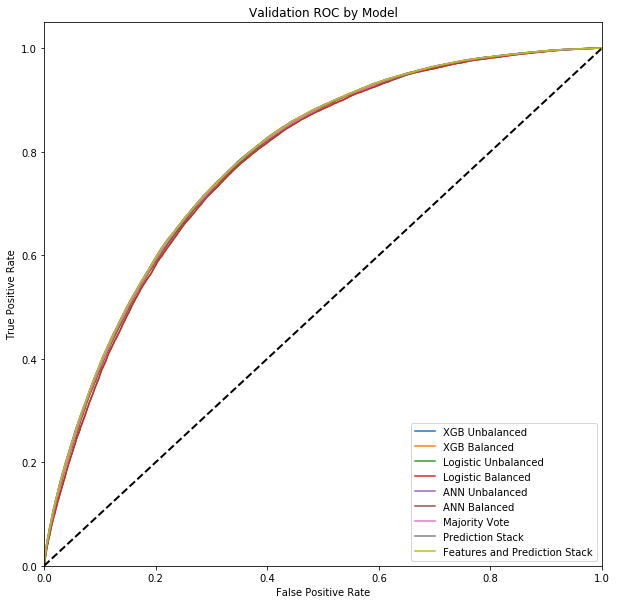


Validation ROC AUC Score by Model:


,ROC AUC
XGB Unbalanced,0.786097
Prediction Stack,0.786064
Features and Prediction Stack,0.786053
XGB Balanced,0.786038
Majority Vote,0.784255
ANN Unbalanced,0.783126
ANN Balanced,0.782150
Logistic Unbalanced,0.778108
Logistic Balanced,0.778076


In [4]:
plt.figure()
lw = 2

fpr_array = np.array([])
tpr_array = np.array([])
thresh_array = np.array([])
mnames = np.array([])

for model in test_prob_pred:
    fpr, tpr, thresh = roc_curve(y_test, test_prob_pred[model])
    fpr_array = np.append(fpr_array,fpr)
    tpr_array = np.append(tpr_array,tpr)
    thresh_array = np.append(thresh_array,thresh)
    mnames = np.append(mnames,[model]*len(fpr))
    plt.plot(fpr, 
             tpr)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC by Model')
plt.legend(test_prob_pred.keys())
plt.show()

print('\nValidation ROC AUC Score by Model:')
pd.DataFrame({'ROC AUC': [roc_auc_score(y_test,
                                        test_prob_pred[model]) \
                          for model in test_prob_pred.keys()]
             },
            index=test_prob_pred.keys()).sort_values('ROC AUC',
                                                     ascending=False)

### Performance by specific threshold

As expected, all models show VERY similar performance (individual curves are not distinguishable). One advantage of using models that return class probabilities is that you can choose thresholds based on what the problem demands. For example, let's say that it is very important that we choose a model that captures at least 80% of all individuals with a history of high blood pressure. With that in mind, I'll summarize the top 10 performing models that meet the threshold. We'll then get a good idea of what sort of performance we can expect under those constraints. 

In [5]:
# Classification matrix, best model while preserving at least 80% precision
roc_df = pd.DataFrame({'Model':mnames,
                       'False Positive Rate':fpr_array,
                      'True Positive Rate':tpr_array,
                      'Threshold':thresh_array})

In [6]:
top10 = roc_df[roc_df['True Positive Rate']>=.8].sort_values(
    'True Positive Rate').head(10)
top10.reset_index(drop=True,inplace=True)
top10

,Model,False Positive Rate,True Positive Rate,Threshold
0,XGB Unbalanced,0.368903,0.800006,0.470034
1,XGB Unbalanced,0.368944,0.800006,0.470031
2,ANN Balanced,0.374237,0.800006,0.360877
3,ANN Unbalanced,0.371427,0.800006,0.550813
4,Majority Vote,0.371142,0.800006,0.433027
5,Majority Vote,0.370898,0.800006,0.433154
6,Logistic Unbalanced,0.379020,0.800006,0.460065
7,Logistic Unbalanced,0.379041,0.800006,0.460049
8,ANN Balanced,0.374338,0.800006,0.360828
9,ANN Unbalanced,0.371468,0.800006,0.550763


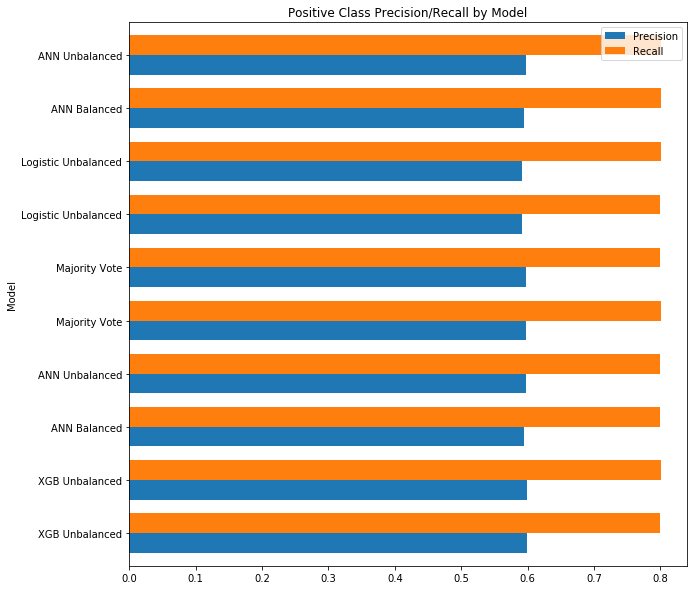

                     Precision    Recall
Model                                   
XGB Unbalanced        0.598485  0.799976
XGB Unbalanced        0.598480  0.800006
Majority Vote         0.597188  0.799976
Majority Vote         0.597052  0.800006
ANN Unbalanced        0.596845  0.799976
ANN Unbalanced        0.596840  0.800006
ANN Balanced          0.595030  0.799976
ANN Balanced          0.594987  0.800006
Logistic Unbalanced   0.591975  0.800006
Logistic Unbalanced   0.591966  0.799976 


                     Precision    Recall
Model                                   
XGB Unbalanced        0.598480  0.800006
Majority Vote         0.597052  0.800006
Logistic Unbalanced   0.591975  0.800006
ANN Balanced          0.594987  0.800006
ANN Unbalanced        0.596840  0.800006
XGB Unbalanced        0.598485  0.799976
ANN Balanced          0.595030  0.799976
ANN Unbalanced        0.596845  0.799976
Majority Vote         0.597188  0.799976
Logistic Unbalanced   0.591966  0.799976


In [7]:
gdf = pd.DataFrame({
    'Precision':[classification_report(y_test,
                      test_prob_pred[top10.Model[i]]>top10.Threshold[i],
                      output_dict=True)['1.0']['precision'] \
                 for i in range(top10.shape[0])],
    'Recall':[classification_report(y_test,
                      test_prob_pred[top10.Model[i]]>top10.Threshold[i],
                      output_dict=True)['1.0']['recall'] \
              for i in range(top10.shape[0])]
}, index = top10.Model)

gdf.plot.barh(width=.75,
             title='Positive Class Precision/Recall by Model')
plt.show()

# Precision/Recall by Precision
print(gdf.sort_values('Precision',ascending=False),'\n\n')

# Precision/Recall by Recall
print(gdf.sort_values('Recall',ascending=False))

### Summary

Again, all of these models perform basically the same. If we're splitting hairs, the XGBoost model that does not adjust for class weights provides the best balance of precision and recall (there's a reason it's often the first out-of-the-box choice for many ML problems).

Not all of the models and steps of this series was necessary, espcially given the nature of the data and the scope of the problem. As an exercise, it was still worthwhile to go through the motions. In practice, the analysis plan will depend on the scope of the problem and may or may not require running multiple models with lots of parameter tuning--especially if desired performance can be achieved quickly. Unless miniscule gains in performance can provide a huge ROI (and sometimes they can!), the amount of time it takes to train and calibrate multiple models will likely be more expensive than the returns you might get from going through the trouble in the first place.

In [10]:
print(classification_report(y_test,
                      [1 for i in y_test]))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     49124
         1.0       0.41      1.00      0.58     33766

   micro avg       0.41      0.41      0.41     82890
   macro avg       0.20      0.50      0.29     82890
weighted avg       0.17      0.41      0.24     82890



In [15]:
print(classification_report(y_test,
                      [np.random.choice([0,1]) for i in y_test]))

              precision    recall  f1-score   support

         0.0       0.59      0.50      0.54     49124
         1.0       0.40      0.50      0.44     33766

   micro avg       0.50      0.50      0.50     82890
   macro avg       0.50      0.50      0.49     82890
weighted avg       0.51      0.50      0.50     82890



In [13]:
(.598485-.41)/.598485

0.31493688229446026

In [18]:
(.8-.5)/.5

0.6000000000000001